In [2]:
import sys
import csv
import seaborn as sns
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
with open('brazil_data/processed_brazil_inv-invResult.pkl','rb') as file:
    result_dict = pkl.load(file)
with open('brazil_data/processed_brazil_inv.pkl','rb') as file:
    data_dict = pkl.load(file)
with open('brazil_data/A757_weather.csv', newline='') as file:
    reader = csv.reader(file)
    header = next(reader)
del header[0]
del header[-1]

In [4]:
xI_ind = data_dict['xI_ind']
xD_ind = data_dict['xD_ind']

xI_obs = data_dict['test']['X'][:,xI_ind]
xD_obs = data_dict['test']['X'][:,xD_ind]

xI_nan = data_dict['test']['nan'][:,xI_ind]
xD_nan = data_dict['test']['nan'][:,xD_ind]
time_steps = np.arange(0,xI_nan.shape[0])

budgets = result_dict['budgets']
improv_mat = result_dict['improv_mat']
time_mat = result_dict['time_mat']

/tmp/ipykernel_5851/1240847393.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


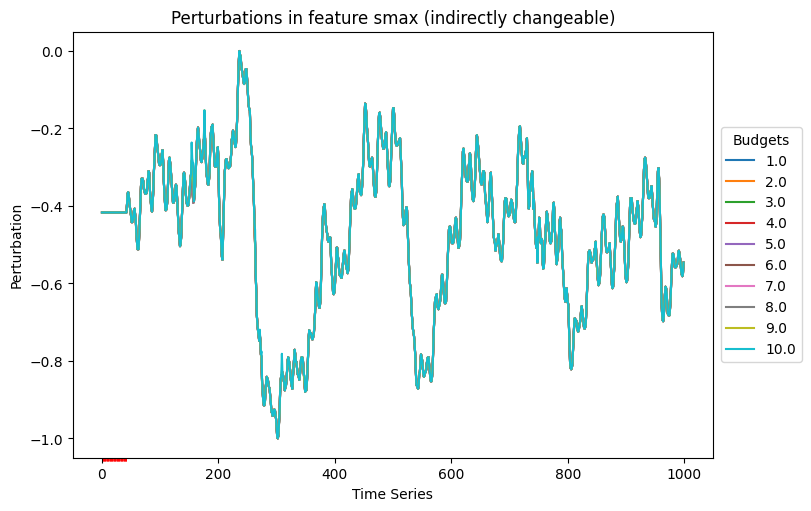

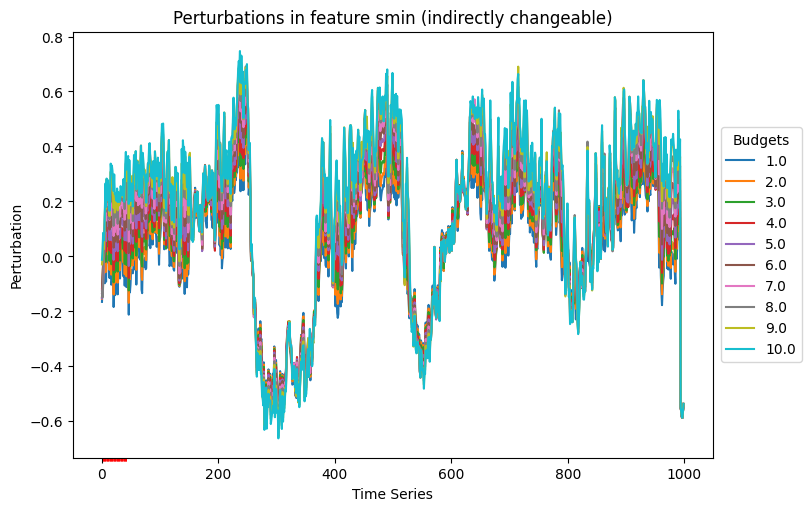

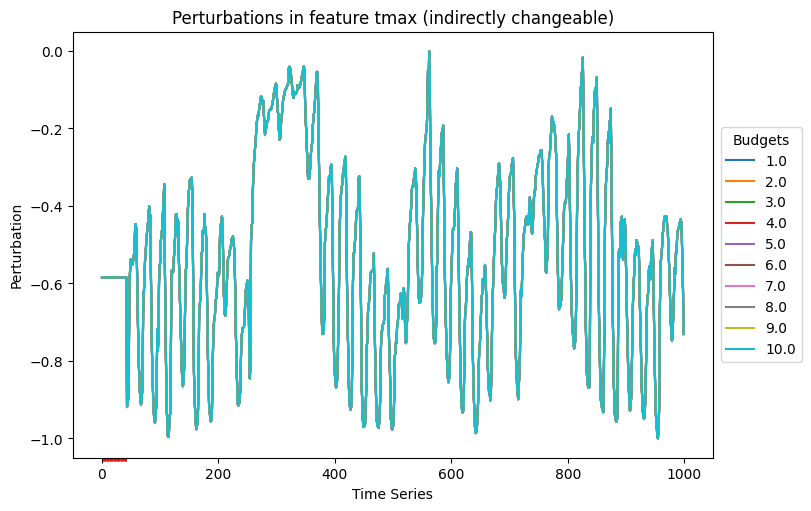

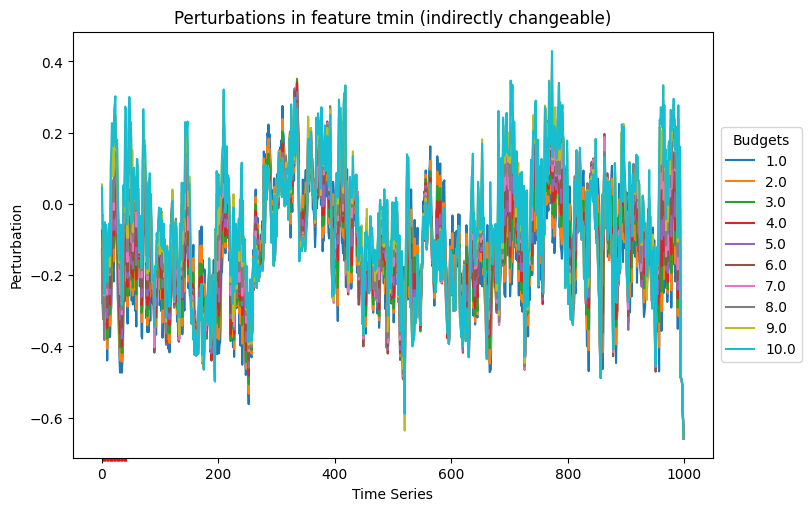

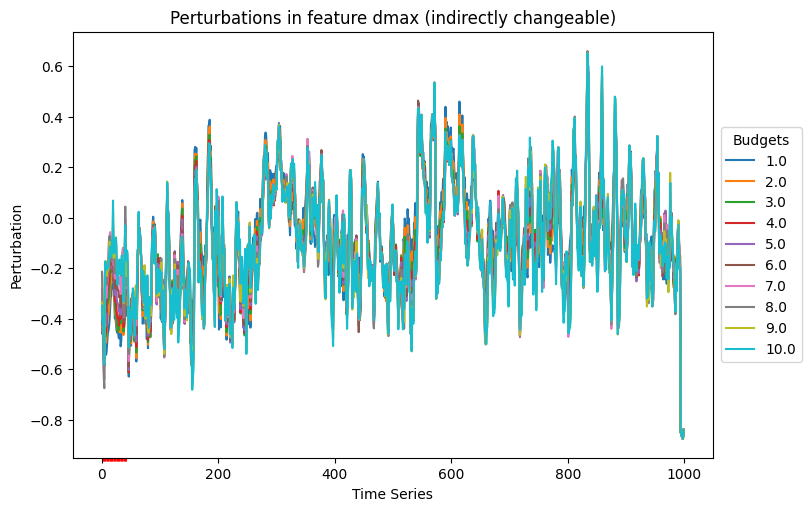

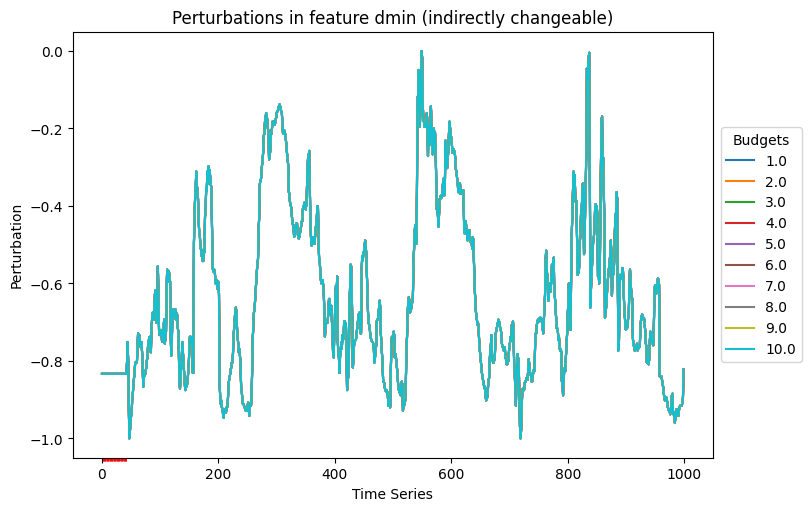

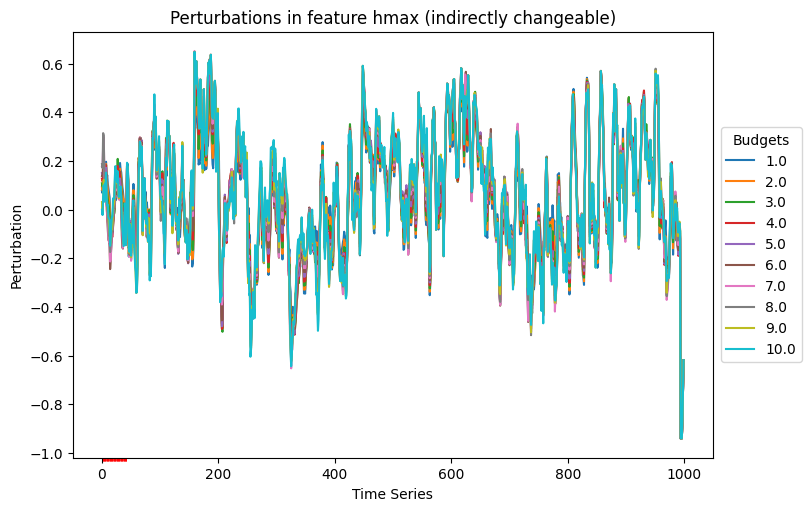

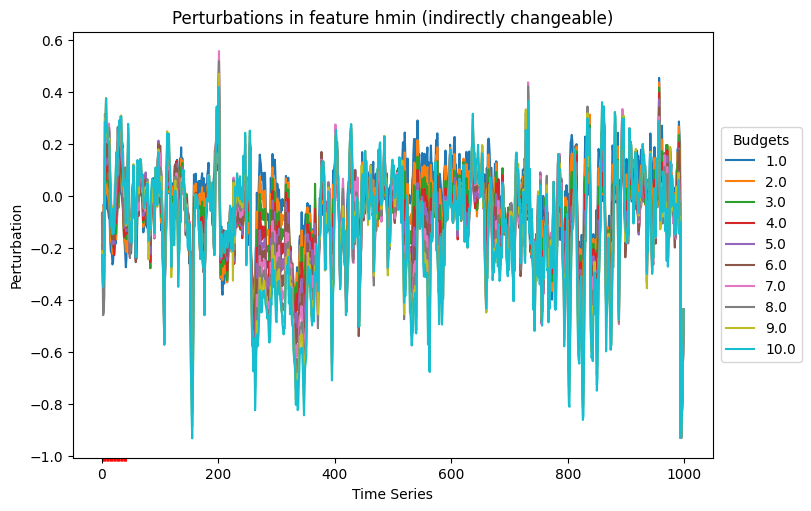

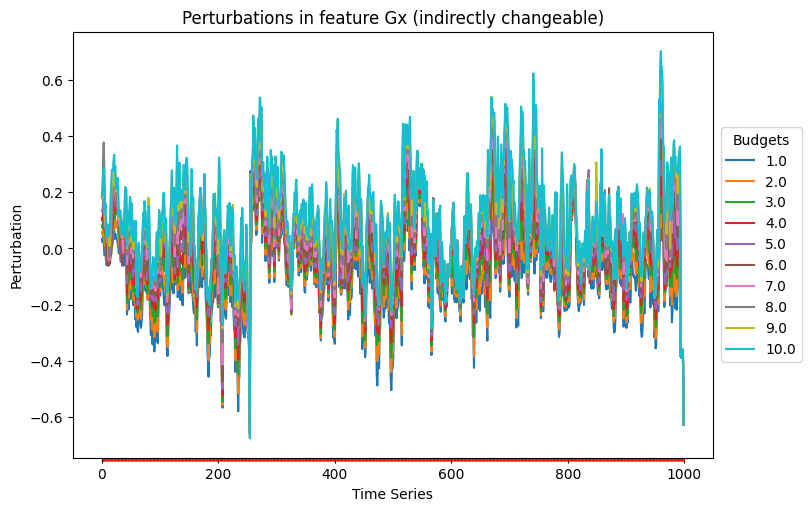

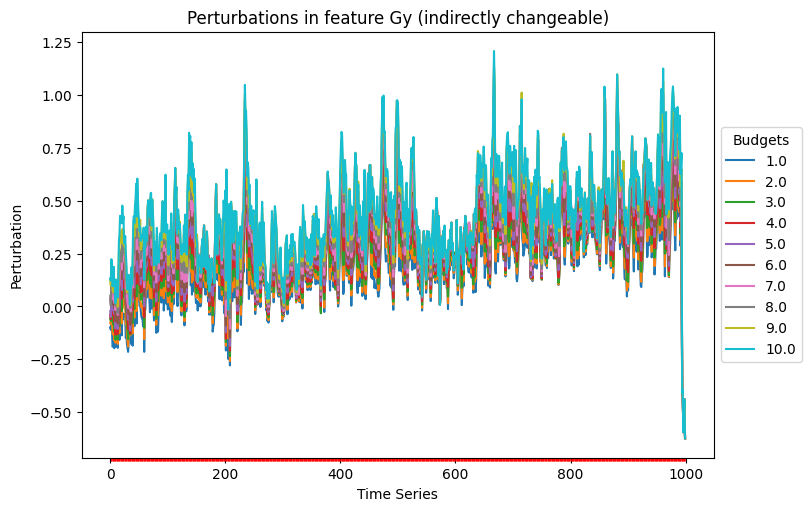

In [4]:
for count, x_ind in enumerate(xI_ind):
    feat_name = header[x_ind]
    fig, ax = plt.subplots(layout='constrained', figsize=(8,5))
    ax.set_title(f'Perturbations in feature {feat_name} (indirectly changeable)')

    xI_feat_nan = xI_nan[:,count]
    plt.xticks(ticks=time_steps[xI_feat_nan==True], minor=True)
    ax.tick_params(axis='x', which='minor', colors='red')

    for b, bud in enumerate(budgets[1:]):
        xI_est = result_dict['xI'][b,:,count]
        xI_diff = xI_est - xI_obs[:,count]
        ax.plot(xI_diff, label=bud)

    ax.legend(title='Budgets', loc='center right', bbox_to_anchor=(1.15,0.5))
    ax.set_xlabel('Time Series')
    ax.set_ylabel('Perturbation')
    fig.show()

In [6]:
xI_est = result_dict['xI'][1,:,]
xI_diff = xI_est - xI_obs[:,0]

In [63]:
pert = result_dict['xD'][1:,:,1] - xD_obs[:,1]

In [73]:
pert[1,:].shape

(1000,)

[Text(0.5, 0, 'Perturbation'), Text(0.5, 1.0, 'Histogram')]

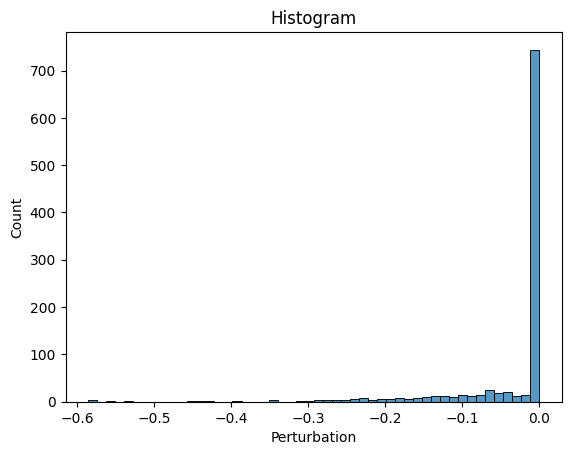

In [78]:
ax = sns.histplot(data=pert[3,:], multiple='stack', bins=50)
ax.set(xlabel='Perturbation', title='Histogram')
#plt.legend(title='Budgets', labels=budgets[1:])